# Analyzing GEOJson segmentation data using cellseg_gsontools

https://okunator.github.io/cellseg_gsontools/getting_started/quick_start/

In [1]:
from cellseg_gsontools.utils import read_gdf
from cellseg_gsontools.plotting import plot_gdf
from cellseg_gsontools.geometry import shape_metric
import pandas as pd
import json

Slide locaten on cheops1: /projects/ag-bozek/data/eso/cgn-slides/nonflot

GEOJson location: https://uni-koeln.sciebo.de/s/qrYzQ3gTDug3T6v    -  sciebo eso-geojsons-mod

https://uni-koeln.sciebo.de/s/xRpvTwx45uSlK2K - sciebo orginal from Tolkach

In [4]:
cells = read_gdf("../data/C 13.35827  he - 2021-12-14 15.48.36_org.geojson")
#cells = read_gdf("../data/B 18.11086 he  - 2022-07-27 11.13.19.geojson")

/Users/fxpopp/miniconda3/envs/geojson/lib/python3.11/site-packages/cellseg_gsontools/utils.py:98: UserWarning: Could not set a class to annotation due to a Error: 'str' object has no attribute 'keys'.
  warnings.warn(f"Could not set a class to annotation due to a Error: {e}.")
/Users/fxpopp/miniconda3/envs/geojson/lib/python3.11/site-packages/cellseg_gsontools/utils.py:98: UserWarning: Could not set a class to annotation due to a Error: 'str' object has no attribute 'keys'.
  warnings.warn(f"Could not set a class to annotation due to a Error: {e}.")
/Users/fxpopp/miniconda3/envs/geojson/lib/python3.11/site-packages/cellseg_gsontools/utils.py:98: UserWarning: Could not set a class to annotation due to a Error: 'str' object has no attribute 'keys'.
  warnings.warn(f"Could not set a class to annotation due to a Error: {e}.")
/Users/fxpopp/miniconda3/envs/geojson/lib/python3.11/site-packages/cellseg_gsontools/utils.py:98: UserWarning: Could not set a class to annotation due to a Error: 'st

In [5]:
cells.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24707 entries, 0 to 24706
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   classification  24707 non-null  object  
 1   geometry        24707 non-null  geometry
 2   class_name      0 non-null      object  
dtypes: geometry(1), object(2)
memory usage: 579.2+ KB


In [7]:
cells.head(4)

,classification,geometry,class_name
0,Connective,"POLYGON ((101888.00000 23254.00000, 101896.000...",None
1,Lymphocyte,"POLYGON ((101774.00000 23282.00000, 101784.000...",None
2,Plasma,"POLYGON ((101804.00000 23288.00000, 101810.000...",None
3,Connective,"POLYGON ((101906.00000 23290.00000, 101914.000...",None


<Axes: >

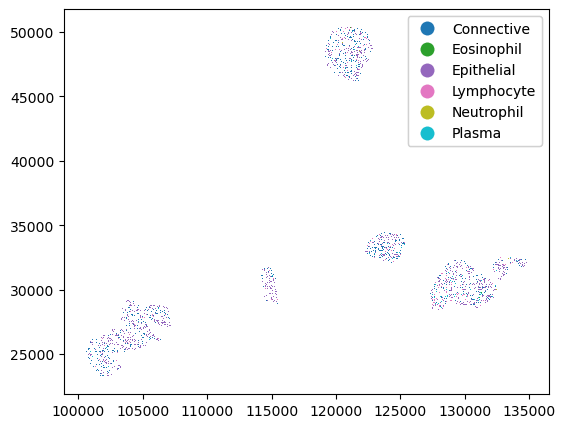

In [8]:
# cells.plot(column="classification", figsize=(15, 15), aspect = 1)

plot_gdf(cells, col="classification", figsize=(15, 5), aspect = 1)

In [9]:
some_cells = cells.head(1000)
some_cells.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   classification  1000 non-null   object  
 1   geometry        1000 non-null   geometry
 2   class_name      0 non-null      object  
dtypes: geometry(1), object(2)
memory usage: 23.6+ KB


In [10]:

some_cells = shape_metric(
    some_cells,
    metrics=["area", "sphericity", "eccentricity"],
    parallel=False
)
some_cells.head(4)

/Users/fxpopp/miniconda3/envs/geojson/lib/python3.11/site-packages/cellseg_gsontools/geometry/shape_metrics.py:605: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf[f"{col_prefix}area"] = gdf.area


,classification,geometry,class_name,area,sphericity,eccentricity
0,Connective,"POLYGON ((101888.00000 23254.00000, 101896.000...",None,468.0,0.686803,0.618590
1,Lymphocyte,"POLYGON ((101774.00000 23282.00000, 101784.000...",None,212.0,0.739813,0.000000
2,Plasma,"POLYGON ((101804.00000 23288.00000, 101810.000...",None,308.0,0.702247,0.574960
3,Connective,"POLYGON ((101906.00000 23290.00000, 101914.000...",None,356.0,0.521597,0.721602


# We can analyze the tumor regions (annotation from Yuri Tolkach) in the high attention areas of our network (pivotal to predict response/non response)

What if high attention areas lie outside the tumor?

See: https://kazumatsuda.medium.com/aggregating-information-of-two-overlaying-geodataframes-using-geopandas-with-code-example-dcee1df74e0e


In [14]:
def select_top_10_percent(df, max=200, ascending=False):
    def select_top_10_percent_(group, max=200, ascending=False):
        n = min(int(len(group) * 0.1), max)  # Calculate the top 10%, ensure at least 1 sample is selected
        return group.sort_values(by='patch-attr', ascending=ascending).head(n)
    return df.groupby('slide-fn', group_keys=False).apply(lambda x: select_top_10_percent_(x,max,ascending))


parquet_pos = '../data/eso-parquet-tables/pos.parquet'
parquet_neg = '../data/eso-parquet-tables/neg.parquet'

df_pos_complete = pd.read_parquet(parquet_pos, engine="fastparquet")
df_neg_complete = pd.read_parquet(parquet_neg, engine="fastparquet")

df_pos_true = df_pos_complete[df_pos_complete['pat-label'] == 1]
df_neg_true = df_neg_complete[df_neg_complete['pat-label'] == 0]

df_pos_true_top = select_top_10_percent(df_pos_true)
df_neg_true_top = select_top_10_percent(df_neg_true, ascending=True)

df_pos = df_pos_true_top
df_neg = df_neg_true_top

/var/folders/vm/t4cx1x8j0tl7z25wth5s95fm0000gn/T/ipykernel_1418/4159702604.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('slide-fn', group_keys=False).apply(lambda x: select_top_10_percent_(x,max,ascending))
/var/folders/vm/t4cx1x8j0tl7z25wth5s95fm0000gn/T/ipykernel_1418/4159702604.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('slide-fn', group_keys=False).app

In [15]:
df_pos.head()
#list(df_pos)
#print(df_pos["slide-fn"])
#print(df_pos["pat-label"])

,num-cells,area-mean,area-median,area-variance,area-skewness,area-kurtosis,num-cells-class-0,num-cells-class-0-ratio,area-class-0-mean,area-class-0-median,...,class-5-neg-spatial-corr,class-5-bb-joins-ratio-adj,class-5-bw-joins-ratio-adj,pseudo-spatial-assoc-class-5,class-6-pos-spatial-corr,class-6-neg-spatial-corr,class-6-bb-joins-ratio-adj,class-6-bw-joins-ratio-adj,pseudo-spatial-assoc-class-6,pat-label
7120,72,359.361111,310.0,26552.741002,0.830561,-0.198142,0,0.0,NaN,NaN,...,0.0,0.000138,0.001313,-0.084577,0.0,0.0,0.000622,0.004008,-0.243781,1
7119,61,446.278689,423.0,32706.804372,0.688541,0.400021,0,0.0,NaN,NaN,...,0.0,0.000000,0.001150,-0.070175,0.0,0.0,0.000192,0.003451,-0.198830,1
7032,126,463.269841,421.0,33894.694603,1.685272,5.435433,0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.000088,0.000987,-0.113260,1
7070,14,492.857143,578.0,39269.208791,-0.824904,-0.590158,0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.000000,0.020089,-0.281250,1
6953,96,493.302083,453.0,48166.297259,1.198908,3.734392,0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


The WSIs had a tile size of 512x512 pixels at x40. The .parquets have the columns 'patch-y' and 'patch-x' . If you would like to analyse the high attention parts of the .geojsons, you can take those columns in the df_pos, df_neg dataframes, multiply the values times 512 to get top-left corner coordinate of the patch, and retrieve the corresponding cells.

For example, if there was a row with patch-y = 20, patch-x = 10, you need to get all the cells of the corresponding .geojson whose nuclei centroids coordinates verify 10240 < y < 10240+512 , 5120 < x < 5120 + 512

In [34]:
#json_path = '/path/to/the/slide.geojson'
#with open(json_path, 'r') as f:
#    json_data = json.load(f) 

df = df_pos

hap_x = high_attention_patch_x = (df[df['slide-fn'] == 'C 13.35827  he - 2021-12-14 15.48.36.ndpi']).iloc[0]['patch-x']
hap_y = high_attention_patch_y = (df[df['slide-fn'] == 'C 13.35827  he - 2021-12-14 15.48.36.ndpi']).iloc[0]['patch-y']

print(hap_x*512 , ' ' , hap_y*512)



hap_cells = cells.cx[hap_x*512:hap_x*512+512, hap_y*512:hap_y*512+512]

hap_cells = cells.cx[0:200000, 0:250000]

hap_cells.head()

#plot_gdf(hap_cells, col="classification", figsize=(10, 10), aspect = 1)


84992.0   50688.0


,classification,geometry,class_name
0,Connective,"POLYGON ((101888.00000 23254.00000, 101896.000...",None
1,Lymphocyte,"POLYGON ((101774.00000 23282.00000, 101784.000...",None
2,Plasma,"POLYGON ((101804.00000 23288.00000, 101810.000...",None
3,Connective,"POLYGON ((101906.00000 23290.00000, 101914.000...",None
4,Lymphocyte,"POLYGON ((101840.00000 23302.00000, 101848.000...",None


In [ ]:
json_path = '/path/to/the/slide.geojson'
with open(json_path, 'r') as f:
    json_data = json.load(f) 

high_attention_patch_y = 20
high_attention_patch_x = 10
important_cells = []
for key, value in json_data.items(): 
    cell_centroid = value['centroid']
    if  (cell_centroid[0]>=high_attention_patch_x*512) and \
        (cell_centroid[0]<(high_attention_patch_x+1)*512) and \
        (cell_centroid[1]>=high_attention_patch_y*512) and \
        (cell_centroid[1]<(high_attention_patch_y+1)*512):
        important_cells.append(value)
# by the end of the loop `important_cells` has all the cells objects of the patch